In [8]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from modules import VBZ

In [2]:
#Path to the data. Change on your own computer
data_path = '/home/gp/Datasets/VBZ/'

# Data load and initial cleanup

>We load the data for the arrival and departure times as well as the data for the tram/busstops.
>We also add some additional columns for further readability and to make future tasks easier

In [5]:
#Loading the data for arrival and departure times, including target and actual times.
path_to_fahrzeiten = data_path + "fahrzeiten_soll_ist_20180715_20180721.csv"
fahrzeiten_data = pd.read_csv(path_to_fahrzeiten);
print(fahrzeiten_data.columns.values)
fahrzeiten_data.head()

['linie' 'richtung' 'betriebsdatum' 'fahrzeug' 'kurs' 'seq_von'
 'halt_diva_von' 'halt_punkt_diva_von' 'halt_kurz_von1' 'datum_von'
 'soll_an_von' 'ist_an_von' 'soll_ab_von' 'ist_ab_von' 'seq_nach'
 'halt_diva_nach' 'halt_punkt_diva_nach' 'halt_kurz_nach1' 'datum_nach'
 'soll_an_nach' 'ist_an_nach1' 'soll_ab_nach' 'ist_ab_nach' 'fahrt_id'
 'fahrweg_id' 'fw_no' 'fw_typ' 'fw_kurz' 'fw_lang' 'umlauf_von'
 'halt_id_von' 'halt_id_nach' 'halt_punkt_id_von' 'halt_punkt_id_nach']


,linie,richtung,betriebsdatum,fahrzeug,kurs,seq_von,halt_diva_von,halt_punkt_diva_von,halt_kurz_von1,datum_von,...,fahrweg_id,fw_no,fw_typ,fw_kurz,fw_lang,umlauf_von,halt_id_von,halt_id_nach,halt_punkt_id_von,halt_punkt_id_nach
0,2,1,15.07.18,2083,6,1,6030,0,DEP4,15.07.18,...,79519,15,2,15,DEP4 - KALK,162622,2251,1906,32451,10563
1,2,1,15.07.18,3034,3,1,478,0,BEZI,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,1306,1502,32822,32369
2,2,1,15.07.18,3034,3,5,601,0,BOES,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,2228,2590,32880,33358
3,2,1,15.07.18,3034,3,4,1861,0,PARA,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,1528,2228,32123,32880
4,2,1,15.07.18,3034,3,3,2396,0,SIHS,15.07.18,...,79515,11,1,11,BEZI - BTIE für Ausfahrt,160677,2657,1528,10574,32123


In [6]:
#Loading the data for the tram/busstops in order to map internal codes to actual stopnames.
path_to_haltestellen = data_path + 'haltestelle.csv';
haltestellen_data = pd.read_csv(path_to_haltestellen);
haltestellen_data.head()

,halt_id,halt_diva,halt_kurz,halt_lang,halt_ist_aktiv
0,143,2570,BirmSte,"Birmensdorf ZH, Sternen/WSL",True
1,309,3356,WaldBir,"Waldegg, Birmensdorferstrasse",True
2,373,6232,FRAF07,"Zürich Flughafen, Fracht",True
3,539,2655,TBAH01,"Thalwil, Bahnhof",True
4,588,3027,FLUG07,"Zürich Flughafen, Bahnhof",True


>We make the arrival and departure times more human readable and put them into datetime objects that we can manipulate later

In [12]:
#Using the date of the connection as well as the seconds since midnight to put arrival and departure times (target and actual) into machine readable format
fahrzeiten_data['ankunft_soll'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                             for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['soll_an_von'].tolist())]);
fahrzeiten_data['ankunft_ist'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                            for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['ist_an_von'].tolist())])
fahrzeiten_data['abfahrt_soll'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                             for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['soll_ab_von'].tolist())]);
fahrzeiten_data['ankunft_ist'] = pd.Series([VBZ.datetime_from_date_and_seconds(d,s) 
                                            for (d,s) in zip(fahrzeiten_data['betriebsdatum'].tolist(),fahrzeiten_data['ist_ab_von'].tolist())])

# Analyzing deviations between target and actual arrival times

>We compute and analyze deviations between target and actual arrival times, looking specifically for delays

In [14]:
#Computing the deviation in arrival times, both in datetime and in seconds
fahrzeiten_data['deviation_datetime'] = fahrzeiten_data['ankunft_ist'] - fahrzeiten_data['ankunft_soll'];
fahrzeiten_data['deviation_in_sec'] = fahrzeiten_data.verspaetung_datetime.apply(lambda d:d.total_seconds());
fahrzeiten_data[['linie','ankunft_ist','ankunft_soll','deviation_datetime','deviation_in_sec']].head()

,linie,ankunft_ist,ankunft_soll,deviation_datetime,deviation_in_sec
0,2,2018-07-15 04:53:31,2018-07-15 04:53:00,00:00:31,31.0
1,2,2018-07-15 04:56:55,2018-07-15 04:56:42,00:00:13,13.0
2,2,2018-07-15 05:03:48,2018-07-15 05:03:42,00:00:06,6.0
3,2,2018-07-15 05:02:35,2018-07-15 05:02:36,-1 days +23:59:59,-1.0
4,2,2018-07-15 05:00:39,2018-07-15 05:00:54,-1 days +23:59:45,-15.0


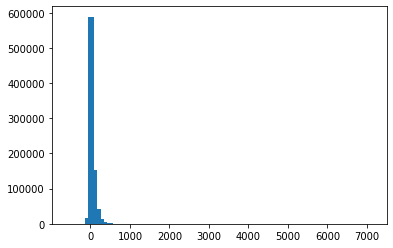

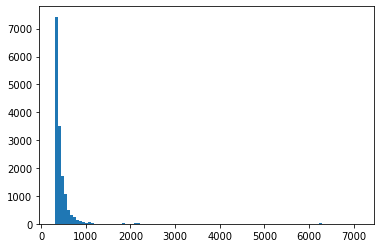

In [21]:
#Plotting the deviation histograms, filtering out any connectionthat arrived 10 minutes 
#early (assumed mistake/outlier) or more than 2h late (assumed failure)
s = fahrzeiten_data['deviation_in_sec'];
plt.hist(s[s>-600][s<7200].tolist(),100);
plt.show()
plt.hist(s[s>300][s<7200].tolist(),100);